# Definitions
$\alpha$ = Angle of attack (AoA)
## Constants and Conversions

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numba import njit
import math as m
from airfoil_db import Airfoil
from joblib import Parallel, delayed
import os
from typing import NamedTuple
import pandas as pd

pwd = os.path.realpath("")
# print(pwd)

inch_to_m = 0.0254 # [=] m/inch
feet_to_m = 0.3048 # [=] m/ft
lb_to_kg = 0.453592 # [=] kg/lb
g = 9.81 # [=] m/s^2

## Reynolds

In [42]:
characteristic_length = 3 * inch_to_m # m
v = 80 * feet_to_m # ft/s, assumed velocity
rho = 1.2041 # Ratio between inertial and viscous forces
mu = 1.5111E-5 # Density of liquid

Re = rho * v * characteristic_length / mu
Re

148057.1113281715

# Wing
## Simulation Domains

In [43]:
class bounds(NamedTuple):
    low: float
    high: float
    step: int = 2

# Test from angle of attack -15° to 21°
alpha_bounds = bounds(-5.0,15.0)
tail_alpha_bounds = bounds(0, 15)

## Airfoil Generation

In [44]:
naca_codes = [ "4412", "4420", "2212", ]

airfoils = []
'''
Stores an airfoil including:
    "Airfoil": Airfoil aerodynamic data
    "NACA": The NACA code of the airfoil
    "CLs": The lift coefficients of the airfoil (over angles of attack)
    "CDs": The drag coefficients of the airfoil (over angles of attack)
'''

# Initialize airfoils
for naca_code in naca_codes:
    airfoils.append( dict({
            "Airfoil" : Airfoil(
                "NACA_{}_airfoil".format(naca_code), 
                {
                    "type" : "database",
                    "geometry" : { "NACA" : naca_code },
                },
            ),
            "Name" : "NACA " + naca_code,
            "Generated" : False,
        })
    )

airfoils.append( dict({
        "Airfoil" : Airfoil(
            "Clark_Y_airfoil", 
            {
                "type" : "database",
                "geometry" :
                    { "outline_points" : "{}/airfoil_outlines/Clark Y.dat".format(
                        pwd,
                    ) },
            },
        ),
        "Name" : "Clark Y",
        "Generated" : False,
    })
)
#'''
airfoils.append( dict({
        "Airfoil" : Airfoil(
            "SD7062_airfoil", 
            {
                "type" : "database",
                "geometry" :
                    { "outline_points" : "{}/airfoil_outlines/SD7062.dat".format(
                        pwd,
                    ) },
            },
        ),
        "Name" : "SD 7062",
        "Generated" : False,
    })
)
#'''
# Set up database degrees of freedom
dofs = {
    "alpha" : { # Angle of attack
        "range" : [
            m.radians(alpha_bounds.low),
            m.radians(alpha_bounds.high)
        ],
        "steps" : 36,
        "index" : 1
    },
    "Rey" : {
        "range" : [20000, 2000000],
        "steps" : 20,
        "index" : 3
    },
    # Assumed that Mach doesn't matter because we are going slow
    # "Mach" : {
    #     "range" : [0.0, 0.4],
    #     "steps" : 3,
    #     "index" : 3
    # }
    # No flaps, not applicable
    # "trailing_flap_deflection" : {
    #     "range" : [m.radians(-20.0), m.radians(20.0)],
    #     "steps" : 7,
    #     "index" : 0
    # },
    # "trailing_flap_fraction" : 0.25
}

# Generate databases using xfoil
def generate_airfoil_database(airfoil):
    # print("Airfoil = ",airfoil)

    # Make a temporary directory for each airfoil so that the xfoil
    # processes do not write into the same directory, preventing
    # errors.
    tmp_dir = "{}/{}".format(
        pwd,
        "tmp/{}".format(airfoil["Name"])
    )
    #print("TMP:", tmp_dir)
    try:
        os.mkdir("tmp")
    except FileExistsError:
        ()
    except:
        raise FileNotFoundError(
            "Your working directory doesn't exist!?"
        )
    try:
        os.mkdir("airfoils")
    except FileExistsError:
        ()
    except:
        raise FileNotFoundError(
            "Your working directory doesn't exist!?"
        )
    try:
        os.mkdir(tmp_dir)
    except FileExistsError:
        print("{} already exists".format(tmp_dir))
    except:
        raise FileNotFoundError(
            "I don't know how you got here"
        )
    
    # Enter the temporary directory and generate airfoil database
    os.chdir(tmp_dir)
    # print("PWD:", os.getcwd())
    airfoil["Airfoil"].generate_database(
        degrees_of_freedom=dofs,
        max_iter=100,
        show_xfoil_output=False,
        show_xfoil_plots=False
    )
    
    # Write the output file
    filename ="{}.txt".format(
        airfoil["Name"]
    )
    airfoil["Airfoil"].export_database(
        filename = filename
    )
    # print(
    #     "{}/{}".format(tmp_dir, filename)
    # )
    # print(
    #     "{}/{}".format(pwd, filename)
    # )
    # Move the output file out of the temporary directory
    os.rename(
        "{}/{}".format(tmp_dir, filename),
        "{}/airfoils/{}".format(pwd, filename),
    )
    airfoil["Generated"] = True
    
    return airfoil

# Do this for all airfoils in multiple processes
airfoils = Parallel(n_jobs=-1)(
    delayed(generate_airfoil_database)(airfoil)
    for airfoil in airfoils
)

# print(airfoils)

# Single process version
# for airfoil in airfoils:
    # airfoil["Airfoil"].generate_database(degrees_of_freedom=dofs, max_iter=100, show_xfoil_output=False, show_xfoil_plots=False)
    # airfoil["Airfoil"].export_database(filename="NACA airfoil {}.txt".format(airfoil["NACA"]))

/home/serzed/Documents/DBF/2024_notebooks/tmp/NACA 4420 already exists
/home/serzed/Documents/DBF/2024_notebooks/tmp/NACA 4412 already exists
Running Xfoil...
         Percent Complete    Flap Deflection [deg]            Flap Fraction
---------------------------------------------------------------------------
Running Xfoil...
         Percent Complete    Flap Deflection [deg]            Flap Fraction
---------------------------------------------------------------------------
                       0%                      0.0                      0.0
                       0%                      0.0                      0.0
/home/serzed/Documents/DBF/2024_notebooks/tmp/NACA 2212 already exists
Running Xfoil...
         Percent Complete    Flap Deflection [deg]            Flap Fraction
---------------------------------------------------------------------------
                       0%                      0.0                      0.0
/home/serzed/Documents/DBF/2024_notebooks/tmp/SD 706

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The follow


Database generation complete.
Convergent results obtained from Xfoil for 100.0% of the requested points.

Database generation complete.
Convergent results obtained from Xfoil for 99.72% of the requested points.


Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO



Database generation complete.
Convergent results obtained from Xfoil for 99.58% of the requested points.

Database generation complete.
Convergent results obtained from Xfoil for 99.44% of the requested points.

Database generation complete.
Convergent results obtained from Xfoil for 99.31% of the requested points.


Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO


### Aerodynamics Testing Domains

In [45]:
alphas = np.linspace(alpha_bounds.low, alpha_bounds.high, 120)
Reys = np.ones_like(alphas) * Re # An array of the same Reynolds number
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for airfoil_index, airfoil in enumerate(airfoils):
    airfoil["alphas"] = alphas # I don't want to find out each of them
                               # have a weird domain the hard way
    airfoil["CLs"] = airfoil["Airfoil"].get_CL(
        alpha=np.deg2rad(alphas),
        Rey=Reys
    )
    airfoil["CDs"] = airfoil["Airfoil"].get_CD(
        alpha=np.deg2rad(alphas),
        Rey=Reys
    )
    # Assign a graph color to the airfoil
    airfoil["graph_color"] = colors[airfoil_index]
    

### Airfoils

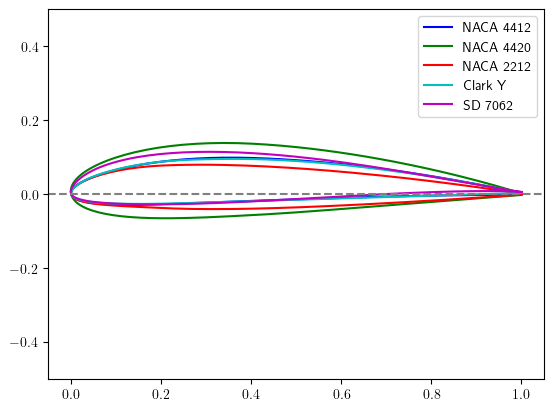

In [46]:
airfoil_shape_domain = np.linspace(0,1,100)
# Show airfoil design
for airfoil in airfoils:
    points_x, points_y = airfoil["Airfoil"].get_outline_points().T
    plt.plot(
        points_x,
        points_y,
        label="{}".format(airfoil["Name"]),
        color = airfoil["graph_color"],
    )
    
plt.ylim([-0.5,0.5])
plt.legend()
plt.axhline(0, linestyle="dashed",color="gray")
plt.show()

## Aerodynamics Characteristics
### By Angle of Attack (α)
#### Critical α calculation
We can find the critical angle of attack by finding where the wing produces maximum lift, and then drops off.

In [47]:
naca_codes = []
critcal_alphas = []
# Find critical angle of attack by finding which angle of attack has
# the highest coefficient of lift
for airfoil in airfoils:
    highest_cls = np.argmax(airfoil["CLs"])
    if hasattr(highest_cls, "__len__"): # Check if the value is a
                                        # list or a scalar
        # Get the index of the last element with the highest CL
        highest_aoa_index = highest_cls[-1]
    else: # Scalar case
        highest_aoa_index = highest_cls
   
    airfoil["critical_alpha"] = airfoil["alphas"][highest_aoa_index]
    naca_codes.append(airfoil["Name"])
    critcal_alphas.append(airfoil["critical_alpha"])


# Display angles of attack
pd.DataFrame({
    "Name": naca_codes,
    "Critical α": critcal_alphas,
})


,Name,Critical α
0,NACA 4412,15.000000
1,NACA 4420,15.000000
2,NACA 2212,13.991597
3,Clark Y,12.142857
4,SD 7062,15.000000


In [48]:
# Plot CL over Angle of Attack
for airfoil in airfoils:
    plt.plot(
        airfoil["alphas"],
        airfoil["CLs"],
        label="{}".format(airfoil["Name"]),
        color= airfoil["graph_color"],
    )
    plt.axvline(
        airfoil["critical_alpha"],
        linestyle = "dashed",
        label = "{} critical α".format(airfoil["Name"]),
        color= airfoil["graph_color"],
    )
plt.title("CL over Angle of Attack")
plt.legend()
plt.xlabel("Angle of attack (α) [°]")
plt.ylabel("CL")
plt.show()

RuntimeError: latex was not able to process the following string:
b'Angle of attack (\\u03b1) [\\xb0]'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpx37lmwor ad016df06312deddf5b01ee26aac0d80.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./ad016df06312deddf5b01ee26aac0d80.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file ad016df06312deddf5b01ee26aac0d80.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character α (U+03B1)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Angle of attack (α
                                   ) [°]}%
No pages of output.
Transcript written on tmpx37lmwor/ad016df06312deddf5b01ee26aac0d80.log.




<Figure size 640x480 with 1 Axes>

As shown in the above graph, NACA 4412's coefficient of lift drops off before the other airfoils, indicating that it stalls earlier compared to the others.
#### Glide α calculation
The point where the CL/CD is the highest is where the best glide α is as the wing can carry the most weight with the least amount of drag. **Note that this does not account for parasitic drag from other elements of the plane**

In [49]:
naca_codes = []
best_alphas = []
# Find critical angle of attack by finding which angle of attack has
# the highest coefficient of lift
for airfoil in airfoils:
    cls_over_cds = airfoil["CLs"]/airfoil["CDs"]
    highest_cls = np.argmax(cls_over_cds)
    if hasattr(highest_cls, "__len__"): # Check if the value is a
                                        # list or a scalar
        # Get the index of the last element with the highest CL
        highest_aoa_index = highest_cls[-1]
    else: # Scalar case
        highest_aoa_index = highest_cls
   
    airfoil["best_alpha"] = airfoil["alphas"][highest_aoa_index]
    naca_codes.append(airfoil["Name"])
    best_alphas.append(airfoil["best_alpha"])


# Display angles of attack
pd.DataFrame({
    "Name": naca_codes,
    "Best α": best_alphas,
})


,Name,Best α
0,NACA 4412,7.605042
1,NACA 4420,8.109244
2,NACA 2212,9.285714
3,Clark Y,5.252101
4,SD 7062,6.596639


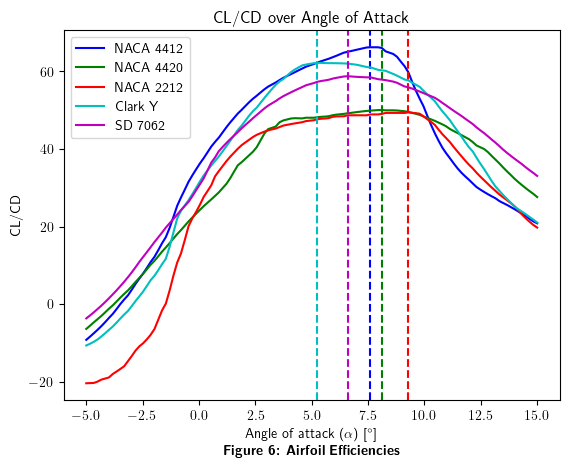

In [50]:
# Plot CL/CD over Angle of Attack
plt.rcParams['text.usetex'] = True
for airfoil in airfoils:
    plt.plot(
        alphas,
        airfoil["CLs"]/airfoil["CDs"],
        label="{}".format(airfoil["Name"]),
        color= airfoil["graph_color"],
    )
    plt.axvline(
        airfoil["best_alpha"],
        linestyle = "dashed",
        #label = r"{} best $\alpha$".format(airfoil["Name"]),
        color= airfoil["graph_color"],
    )
plt.title("CL/CD over Angle of Attack")
plt.legend()
plt.xlabel(r'\begin{center}Angle of attack ($\alpha$) [$^\circ$] \\*\textbf{Figure 6: Airfoil Efficiencies}\end{center}')
plt.ylabel("CL/CD")
plt.show()

The cofficient of lift divided by the coefficient of drag over the angle of attack is the highest for NACA 4412. This means that NACA 4412 is the most efficient airfoil.

In [51]:
# Plot CD over Angle of Attack
for airfoil in airfoils:
    plt.plot(
        alphas,
        airfoil["CDs"],
        label="{}".format(airfoil["Name"]),
        color= airfoil["graph_color"],
    )
plt.title("CD over Angle of Attack")
plt.legend()
plt.xlabel("Angle of attack (α) [°]")
plt.ylabel("CD")
plt.show()

RuntimeError: latex was not able to process the following string:
b'Angle of attack (\\u03b1) [\\xb0]'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmptbtea309 ad016df06312deddf5b01ee26aac0d80.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./ad016df06312deddf5b01ee26aac0d80.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file ad016df06312deddf5b01ee26aac0d80.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character α (U+03B1)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Angle of attack (α
                                   ) [°]}%
No pages of output.
Transcript written on tmptbtea309/ad016df06312deddf5b01ee26aac0d80.log.




<Figure size 640x480 with 1 Axes>

### CL/CD Ratio

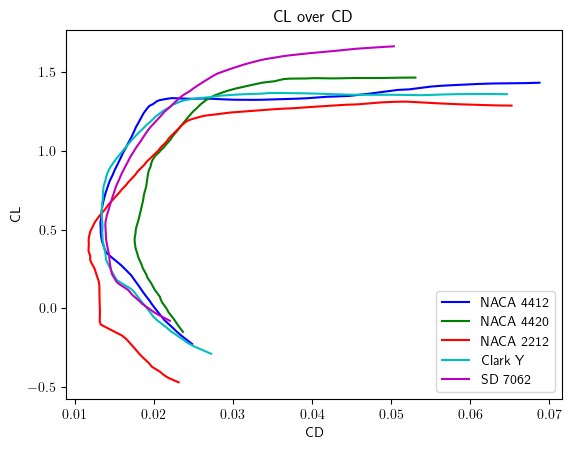

In [52]:
# Plot CL/CD over Angle of Attack
for airfoil in airfoils:
    plt.plot(
        airfoil["CDs"],
        airfoil["CLs"],
        label="{}".format(airfoil["Name"]),
        color= airfoil["graph_color"],
    )
plt.title("CL over CD")
plt.legend()
plt.xlabel("CD")
plt.ylabel("CL")
plt.show()

# Tail
## Simulation Domains

In [53]:
class bounds(NamedTuple):
    low: float
    high: float
    step: int = 2

# Test from angle of attack -15° to 21°
alpha_bounds = bounds(-5.0,5.0)
flap_bounds = np.linspace(-20, 20, 7)

## Airfoil Generation

In [ ]:
naca_codes = [ "0012", "0010" ]

tail_airfoils = []
'''
Stores an airfoil including:
    "Airfoil": Airfoil aerodynamic data
    "NACA": The NACA code of the airfoil
    "CLs": The lift coefficients of the airfoil (over angles of attack)
    "CDs": The drag coefficients of the airfoil (over angles of attack)
    "Trailing Flap": How deflected the trailing flap is.
'''

# Initialize airfoils
for naca_code in naca_codes:
    tail_airfoils.append( dict({
            "Airfoil" : Airfoil(
                "NACA_{}_airfoil".format(naca_code), 
                {
                    "type" : "database",
                    "geometry" : { "NACA" : naca_code },
                },
            ),
            "Name" : "NACA " + naca_code,
            "Generated" : False,
        })
    )

# Set up database degrees of freedom
dofs = {
    "alpha" : { # Angle of attack
        "range" : [
            m.radians(tail_alpha_bounds.low),
            m.radians(tail_alpha_bounds.high)
        ],
        "steps" : 36,
        "index" : 1
    },
    "Rey" : {
        "range" : [20000, 2000000],
        "steps" : 20,
        "index" : 3
    },
    # Assumed that Mach doesn't matter because we are going slow
    # "Mach" : {
    #     "range" : [0.0, 0.4],
    #     "steps" : 3,
    #     "index" : 3
    # }
    # No flaps, not applicable
    # "trailing_flap_deflection" : {
    #     "range" : [m.radians(-20.0), m.radians(20.0)],
    #     "steps" : 7,
    #     "index" : 0
    # },
    # "trailing_flap_fraction" : 0.25
}


# Do this for all airfoils in multiple processes
tail_airfoils = Parallel(n_jobs=-1)(
    delayed(generate_airfoil_database)(airfoil)
    for airfoil in tail_airfoils
)

print(tail_airfoils)

# Single process version
# for airfoil in tail_airfoils:
    # airfoil["Airfoil"].generate_database(degrees_of_freedom=dofs, max_iter=100, show_xfoil_output=False, show_xfoil_plots=False)
    # airfoil["Airfoil"].export_database(filename="NACA airfoil {}.txt".format(airfoil["NACA"]))

/home/serzed/Documents/DBF/2024_notebooks/tmp/NACA 0012 already exists
Running Xfoil...
         Percent Complete    Flap Deflection [deg]            Flap Fraction
---------------------------------------------------------------------------
                       0%                      0.0                      0.0
/home/serzed/Documents/DBF/2024_notebooks/tmp/NACA 0010 already exists
Running Xfoil...
         Percent Complete    Flap Deflection [deg]            Flap Fraction
---------------------------------------------------------------------------
                       0%                      0.0                      0.0


Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO
Note: The following floating-point exceptions are signalling: IE


Database generation complete.
Convergent results obtained from Xfoil for 98.75% of the requested points.


### Aerodynamics Testing Domains

In [ ]:
alphas = np.linspace(alpha_bounds.low, alpha_bounds.high, 120)
Reys = np.ones_like(alphas) * Re # An array of the same Reynolds number
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for airfoil_index, airfoil in enumerate(tail_airfoils):
    airfoil["alphas"] = alphas # I don't want to find out each of them
                               # have a weird domain the hard way
    airfoil["CLs"] = airfoil["Airfoil"].get_CL(
        alpha=np.deg2rad(alphas),
        Rey=Reys
    )
    airfoil["CDs"] = airfoil["Airfoil"].get_CD(
        alpha=np.deg2rad(alphas),
        Rey=Reys
    )
    # Assign a graph color to the airfoil
    airfoil["graph_color"] = colors[airfoil_index]
    

### Airfoils

/tmp/ipykernel_47536/1815820867.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


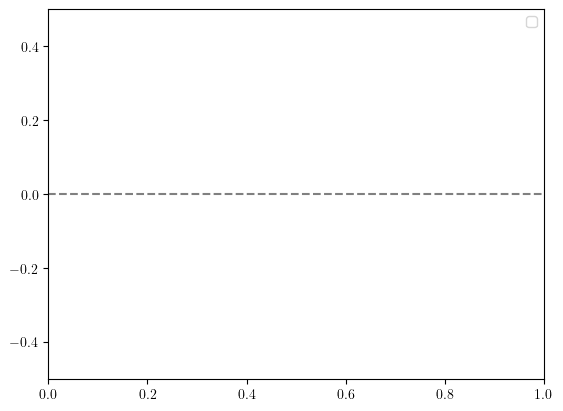

In [ ]:
airfoil_shape_domain = np.linspace(0,1,100)
# Show airfoil design
for airfoil in tail_airfoils:
    points_x, points_y = airfoil["Airfoil"].get_outline_points().T
    plt.plot(
        points_x,
        points_y,
        label="{}".format(airfoil["Name"]),
        color = airfoil["graph_color"],
    )
    
plt.ylim([-0.5,0.5])
plt.legend()
plt.axhline(0, linestyle="dashed",color="gray")
plt.show()